## Normalizing Flows

Your task is to implement a version of Normalizing Flow for image generation. Our implementation will be based on RealNVP (https://arxiv.org/pdf/1605.08803.pdf) and we will be training on one class from MNIST. Your task is to read the paper in details and implement simple version of the algorithm from the paper:


1. Implement simple CouplingLayers (see RealNVP paper) with neural networks using a few fully connected layers with hidden activations of your choice. More on the CouplingLayers can be also found in https://arxiv.org/pdf/1410.8516.pdf. Remember to implement properly logarithm of a Jacobian determinant calculation. Implement only single scale architecture, ignore multiscale architecture with masked convolution and batch normalization. (2 points)
2. Implement RealNVP class combining many CouplingLayers with proper masking pattern (rememeber to alternate between unmodified pixels) with forward and inverse flows. (1 points)
3. Implement a loss function `nf_loss` (data log-likelihood) for the model. Hint: check `torch.distributions` (1 point)
4. Train your model to achieve good looking samples (similar to training set - similar to that appended to assignmenmt on moodle). The training process should take between 5-10 minutes. (2 points)
5. Sample from your model and pick 2 images (as visually different as possible) from your samples and plot 10 images that correspond to equally spaced linear interpolations in latent space between those images you picked. (1 point)
6. Use method from section 5.2 from https://arxiv.org/pdf/1410.8516.pdf with trained model and inpaint 5 sampled images with different random parts of your image occluded (50% of the image must be occluded). (2 point)
7. Write a report describing your solution, add loss plots and samples from the model. Write which hyperparameter sets worked for you and which did not. (1 point)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import distributions
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(root=r'./mnist/', 
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = DataLoader(x, batch_size=128, shuffle=True)

In [3]:
def plot(samples):
    length = len(samples)
    fig, ax = plt.subplots(1, length, figsize=(2*length, 2))
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    for j in range(length):
        ax[j].imshow(samples[j].cpu().numpy())
        ax[j].axis('off')
    plt.show()
    

class Coupling_layer(nn.Module):        
    def __init__(self, input_size, hidden_size, mask):
        super().__init__()

        self.mask = mask
        self.s_net = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, input_size),
                                    nn.Tanh(),
                                    )
        self.t_net = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, input_size),
                                   )

 
    def forward_flow(self, x):
        mx = x * self.mask
        s = self.s_net(mx)
        t = self.t_net(mx)
        y = mx + (1-self.mask) * (x*torch.exp(s) + t)
        
        logdetJ = s.sum(dim=1)

        return y, logdetJ

    def inverse_flow(self, z):
        mz = z * self.mask
        s = self.s_net(mz)
        t = self.t_net(mz)
        y = mz + (1-self.mask) * (z-t) * torch.exp(-s)

        return y

 
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, mask, n_blocks):
        super().__init__()
        
        modules_list = [(Coupling_layer(input_size, hidden_size, mask if i%2==0 else 1-mask)) 
                            for i in range(n_blocks)]

        self.modules_list = nn.ModuleList(modules_list)
    
    def forward_flow(self, x):
        x = x.flatten(start_dim=1)
        logdetJ_sum = 0

        for module in self.modules_list:
            x, logdetJ = module.forward_flow(x)
            logdetJ_sum += logdetJ
    
        return x, logdetJ_sum

    def inverse_flow(self, z):
        z = z.flatten(start_dim=1)
        
        for module in reversed(self.modules_list):
            z = module.inverse_flow(z)
            
        return z.view(-1, 28, 28)
        

prior = distributions.MultivariateNormal(torch.zeros(28*28).to(device), torch.eye(28*28).to(device))     
def nf_loss(z, logdetJ):
    prior_z = prior.log_prob(z)
    return - (prior_z + logdetJ).mean()

In [4]:
n_epochs = 1000
lr = 0.0002
hidden_size = 28*28*2
n_blocks = 8

mask = torch.concat([torch.zeros(28*28//2), torch.ones(28*28//2)]).to(device)
model = RealNVP(28*28, hidden_size, mask, n_blocks).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 1/1000 Loss: -2564.7378


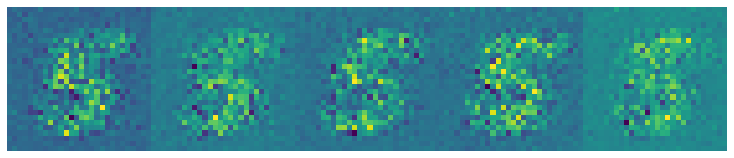

Epoch: 21/1000 Loss: -4592.8310


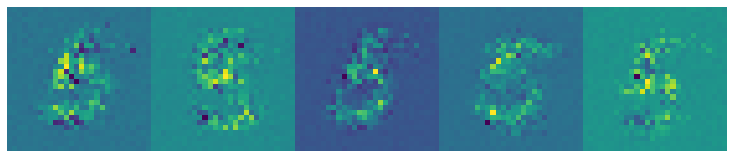

Epoch: 41/1000 Loss: -4704.3393


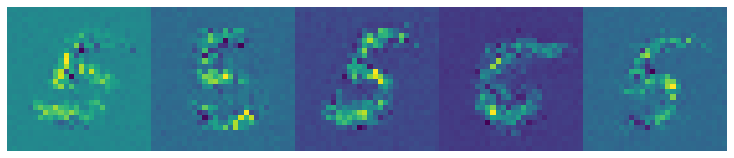

Epoch: 61/1000 Loss: -4756.0815


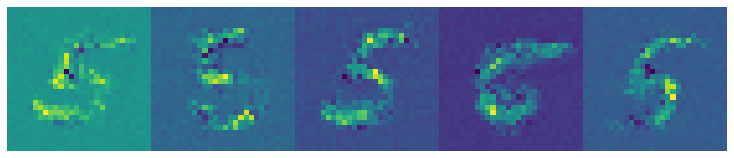

Epoch: 81/1000 Loss: -4791.6307


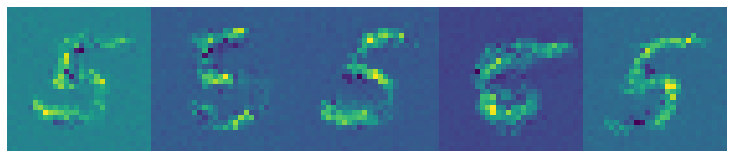

Epoch: 101/1000 Loss: -4816.1470


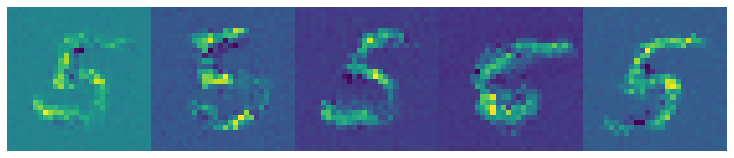

Epoch: 121/1000 Loss: -4834.9289


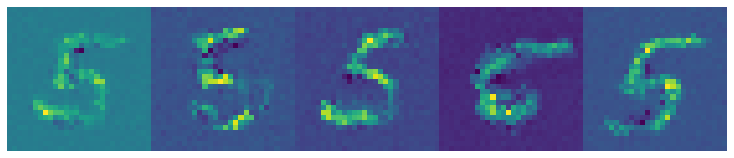

Epoch: 141/1000 Loss: -4852.9271


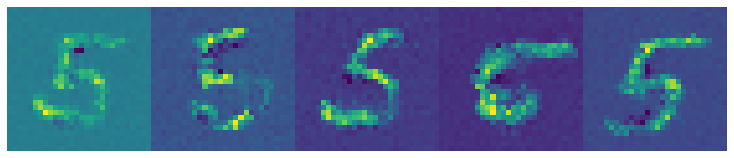

Epoch: 161/1000 Loss: -4867.5169


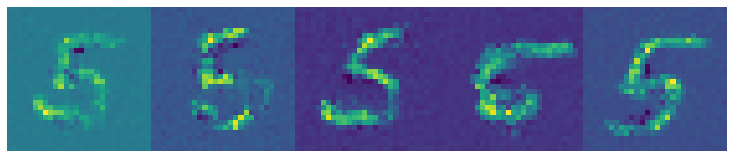

Epoch: 181/1000 Loss: -4875.6835


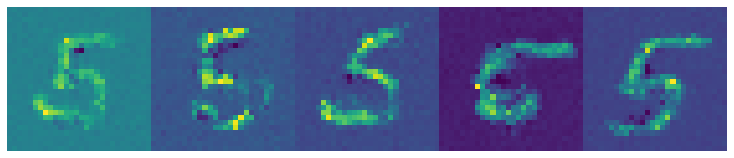

Epoch: 201/1000 Loss: -4887.9112


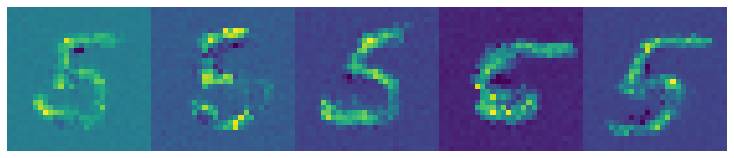

Epoch: 221/1000 Loss: -4899.5552


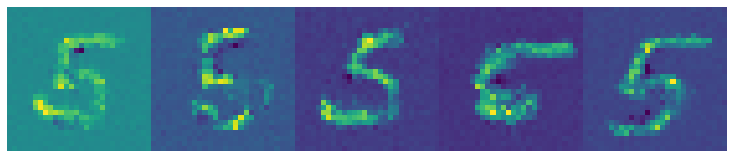

Epoch: 241/1000 Loss: -4908.7532


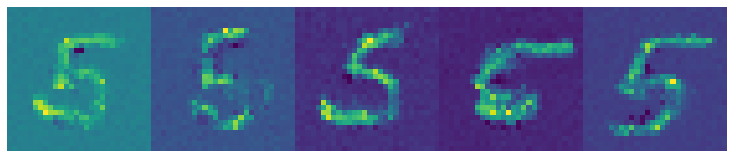

Epoch: 261/1000 Loss: -4914.0078


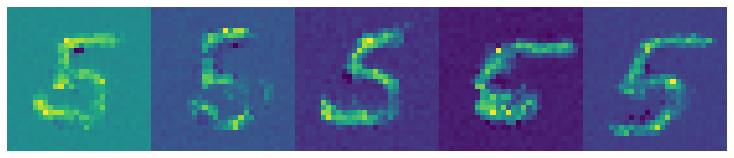

Epoch: 281/1000 Loss: -4920.8150


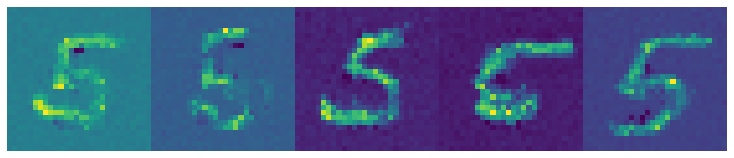

Epoch: 301/1000 Loss: -4924.3440


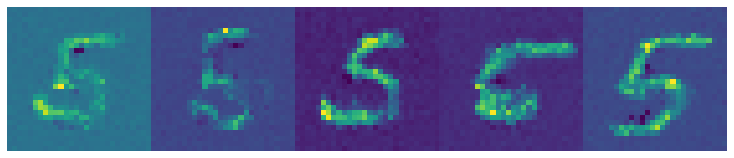

Epoch: 321/1000 Loss: -4930.0736


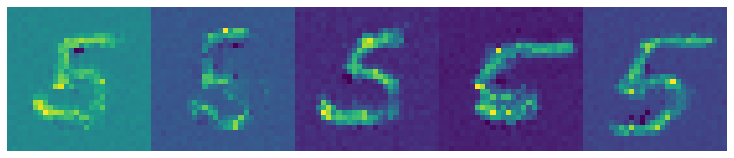

Epoch: 341/1000 Loss: -4937.7711


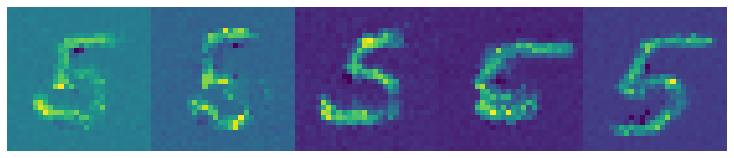

Epoch: 361/1000 Loss: -4943.9539


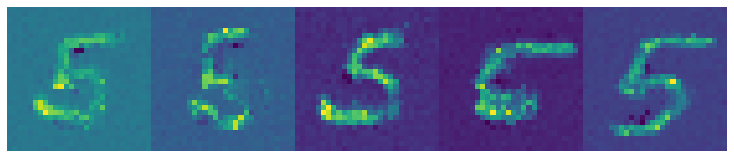

Epoch: 381/1000 Loss: -4946.9607


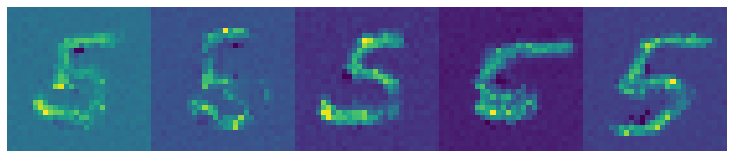

Epoch: 401/1000 Loss: -4949.6054


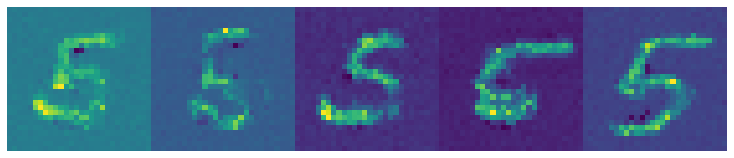

Epoch: 421/1000 Loss: -4951.3852


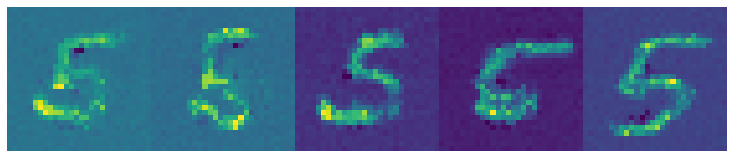

Epoch: 441/1000 Loss: -4954.8047


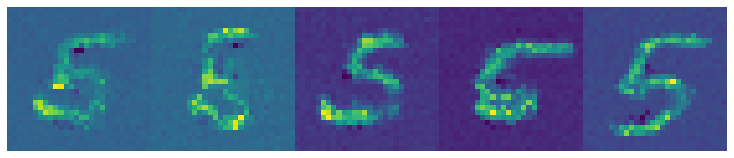

Epoch: 461/1000 Loss: -4958.1839


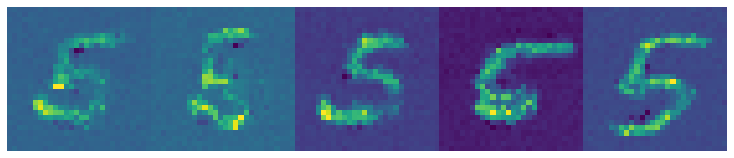

Epoch: 481/1000 Loss: -4967.5758


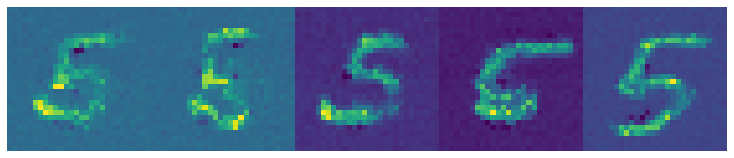

Epoch: 501/1000 Loss: -4968.5421


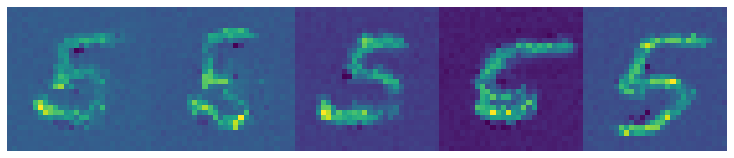

Epoch: 521/1000 Loss: -4971.0345


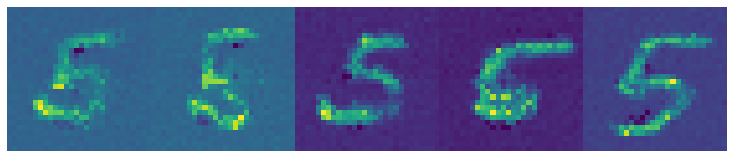

Epoch: 541/1000 Loss: -4973.0253


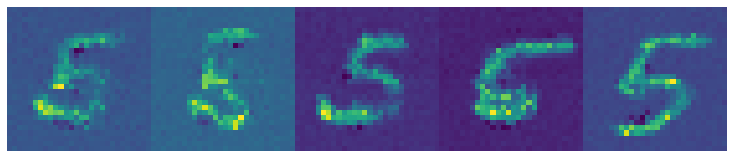

Epoch: 561/1000 Loss: -4973.2490


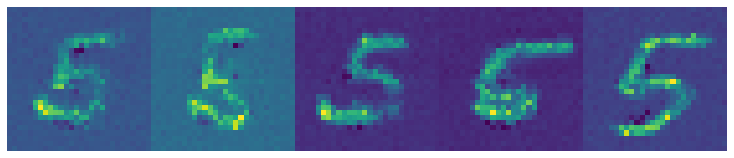

Epoch: 581/1000 Loss: -4967.0618


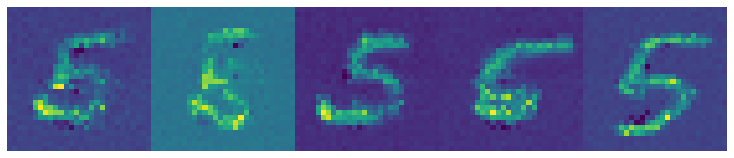

Epoch: 601/1000 Loss: -4972.7737


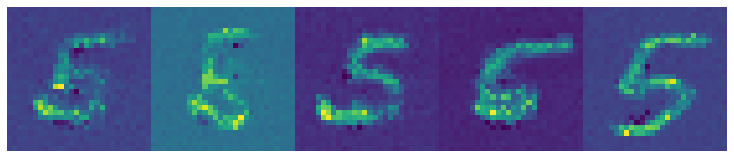

Epoch: 621/1000 Loss: -4979.4132


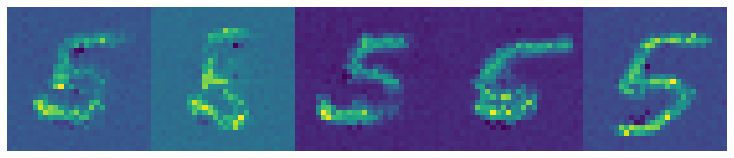

Epoch: 641/1000 Loss: -4978.2893


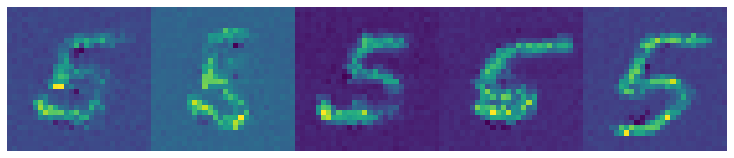

Epoch: 661/1000 Loss: -4987.7445


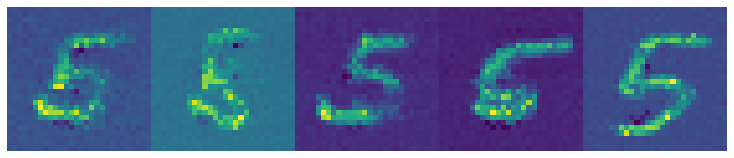

Epoch: 681/1000 Loss: -4986.0801


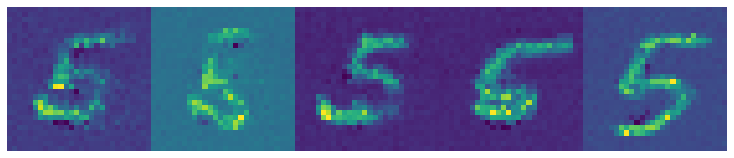

Epoch: 701/1000 Loss: -4988.8214


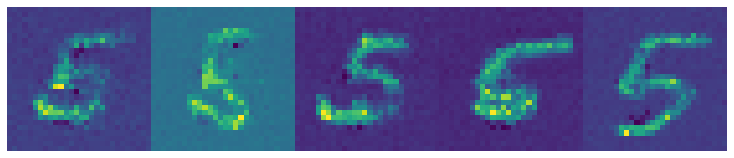

Epoch: 721/1000 Loss: -4987.0733


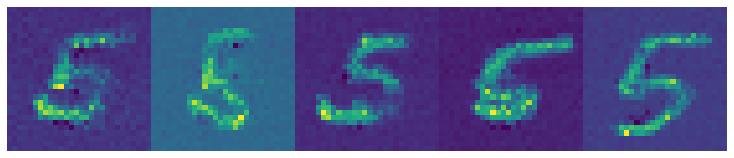

Epoch: 741/1000 Loss: -4972.5285


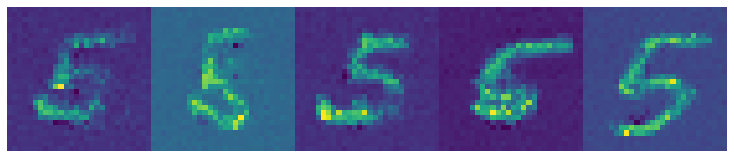

Epoch: 761/1000 Loss: -4993.4549


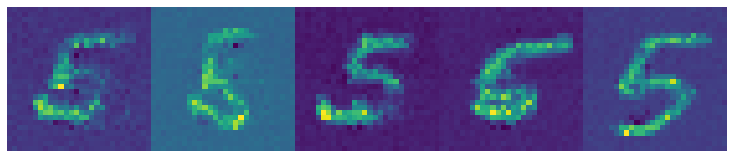

Epoch: 781/1000 Loss: -4999.9525


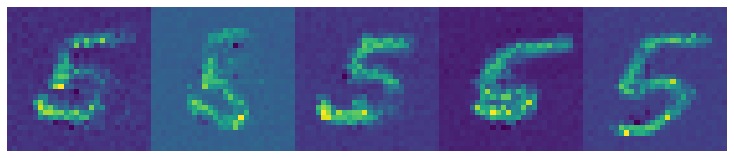

Epoch: 801/1000 Loss: -5000.5649


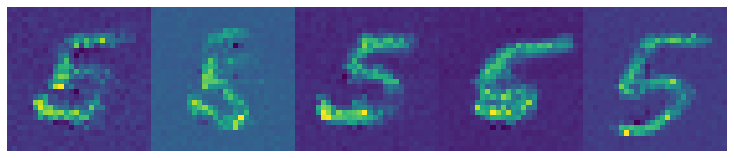

Epoch: 821/1000 Loss: -4999.1130


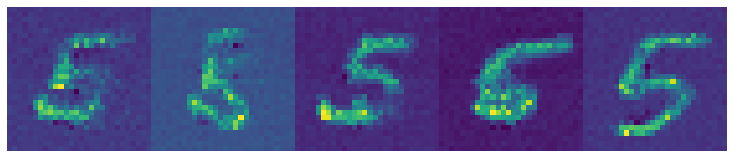

Epoch: 841/1000 Loss: -5003.0649


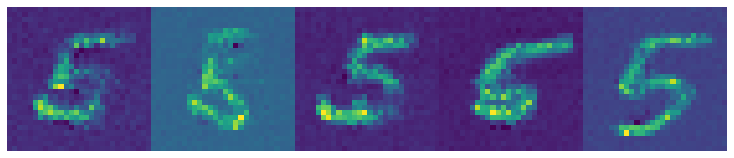

Epoch: 861/1000 Loss: -5005.7687


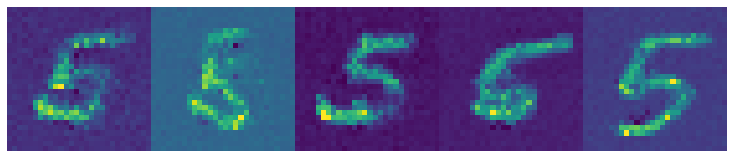

Epoch: 881/1000 Loss: -5007.2042


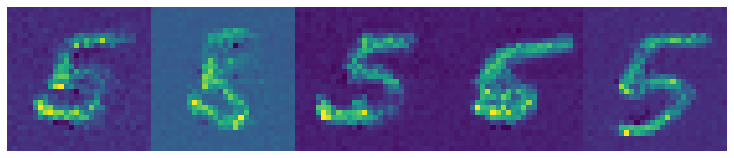

Epoch: 901/1000 Loss: -5008.5170


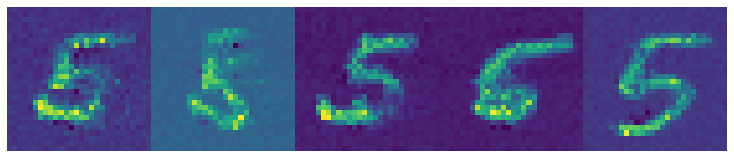

Epoch: 921/1000 Loss: -5009.4953


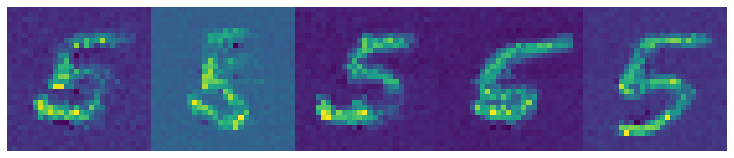

Epoch: 941/1000 Loss: -5004.3408


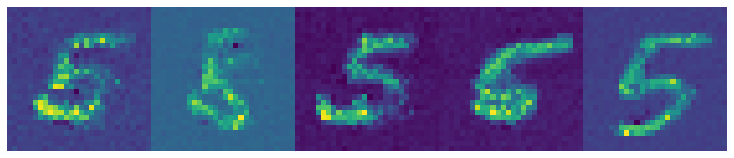

Epoch: 961/1000 Loss: -5012.0779


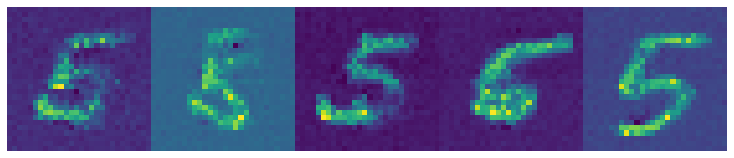

Epoch: 981/1000 Loss: -5012.5158


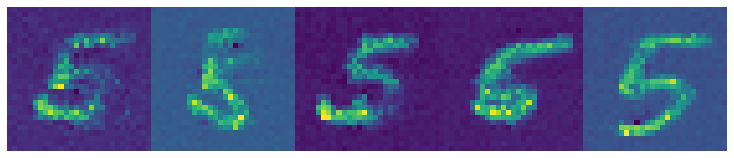

In [5]:
sample_noise = torch.randn(5,28,28).to(device)

for i in range(n_epochs):
    model.train()
    loss_acc = 0
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x = (x.float() + torch.randn(x.shape) / 64.).to(device)
        z, logdetJ = model.forward_flow(x)
        loss = nf_loss(z, logdetJ)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()
    
    if i%20 == 0:
        print(f'Epoch: {i + 1}/{n_epochs} Loss: {(loss_acc / (j+1)):.4f}')
        with torch.no_grad():
            model.eval()
            samples = model.inverse_flow(sample_noise)
            plot(samples)

In [6]:
torch.save(model.state_dict(), 'checkpoint.ckpt')

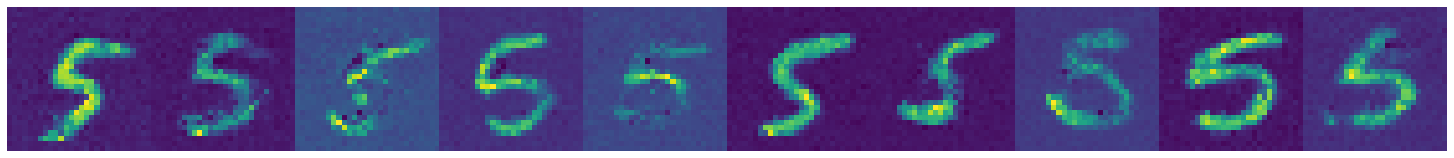

In [7]:
sample_noise = torch.randn(10,28,28).to(device)
with torch.no_grad():
    model.eval()
    samples = model.inverse_flow(sample_noise)
    plot(samples)

In [8]:
z1 = sample_noise[1]
z2 = sample_noise[9]

dist = (z2-z1)/9
z_seq = [z1 + i*dist for i in range(10)]
z_seq = torch.stack(z_seq)

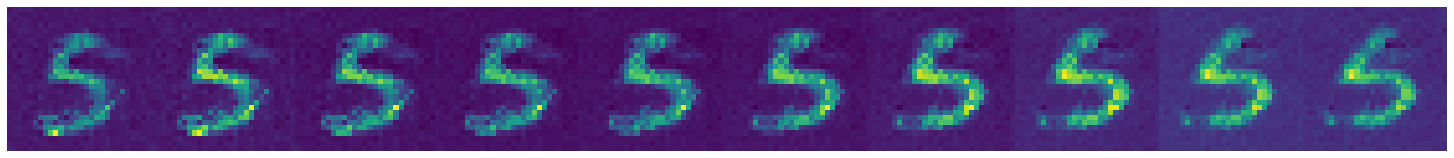

In [9]:
with torch.no_grad():
    model.eval()
    samples = model.inverse_flow(z_seq)
    plot(samples)

## Report

I used the architectures from the given paper. As a mask I used a tensor which upper half contained zeros and lower half ones, and I reversed the mask on every block.

I used 8 blocks. As a learning rate I first used 0.001, but after around 100 or 200 epoch images started to getting worse, so I change this parameter to 0.0002 and with this everything works.

Sample images:

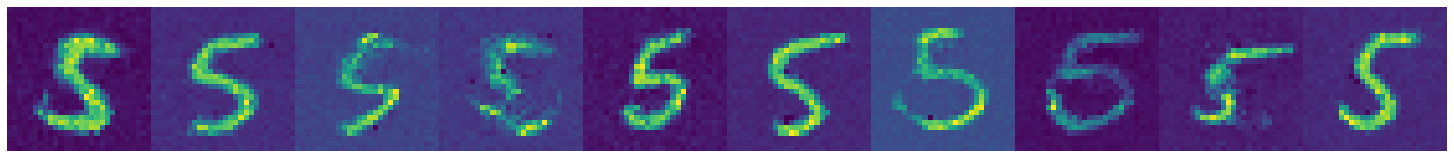

In [10]:
sample_noise = torch.randn(10,28,28).to(device)
with torch.no_grad():
    model.eval()
    samples = model.inverse_flow(sample_noise)
    plot(samples)